/tmp/ipykernel_27843/4204554645.py:136: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


Saved to: /home/kelemnegasi/workspace/transformers-project/binding/analysis/final_reports/numerical_estimation_tasks_2d_line_agg_bar_per_model.pdf


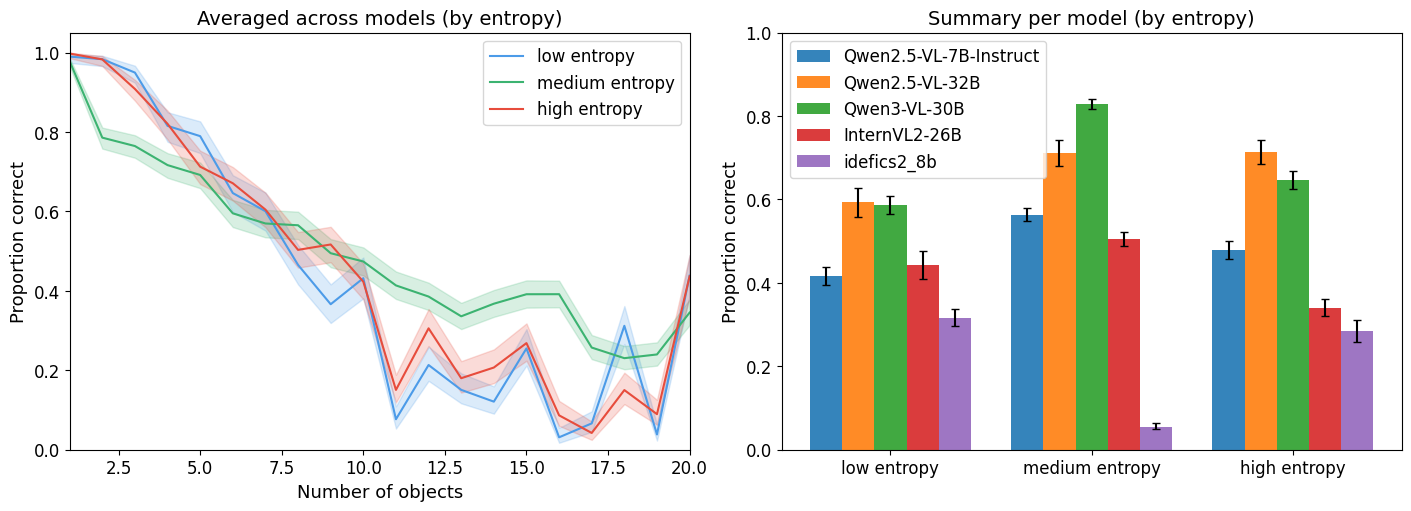

In [3]:
# Numerical Estimation (2D):
# LEFT: line chart aggregated across models (pooled counts) stratified by entropy
# RIGHT: bar chart kept PER-MODEL (original behavior), NOT aggregated

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Binomial 95% CI (Wilson)
# ----------------------------
def wilson_ci(k, n, z=1.96):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    low = np.zeros_like(k, dtype=float)
    high = np.zeros_like(k, dtype=float)

    mask = n > 0
    if not np.any(mask):
        return low, high

    phat = np.zeros_like(k, dtype=float)
    phat[mask] = k[mask] / n[mask]

    denom = 1.0 + (z**2) / n[mask]
    center = (phat[mask] + (z**2) / (2.0 * n[mask])) / denom
    half = (z / denom) * np.sqrt(
        (phat[mask] * (1.0 - phat[mask]) + (z**2) / (4.0 * n[mask])) / n[mask]
    )

    low[mask] = np.clip(center - half, 0, 1)
    high[mask] = np.clip(center + half, 0, 1)
    return low, high

# ----------------------------
# Condition mapping
# ----------------------------
def map_entropy(lbl):
    if lbl == "low_entropy":
        return "low_entropy"
    if lbl == "high_entropy":
        return "high_entropy"
    if lbl in ("medium_entropy_same_shape", "medium_entropy_same_color"):
        return "medium_entropy"
    return None  # ignore control_distinct by default

# ----------------------------
# Per-model pooling (keeps counts)
# ----------------------------
def prepare_pooled(df_raw, model_name):
    df = df_raw.copy()
    df["model"] = model_name
    df["entropy_group"] = df["condition_label"].map(map_entropy)
    df = df[df["entropy_group"].notnull()].copy()

    pooled = (
        df.groupby(["model", "entropy_group", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
          .sum()
          .sort_values(["entropy_group", "n_objects"])
    )
    pooled["accuracy"] = pooled["n_correct"] / pooled["n_trials"]
    lo, hi = wilson_ci(pooled["n_correct"].values, pooled["n_trials"].values)
    pooled["ci_low"] = lo
    pooled["ci_high"] = hi
    return pooled

def summary_by_entropy(pooled_one_model):
    summ = (
        pooled_one_model.groupby(["model", "entropy_group"], as_index=False)[["n_trials", "n_correct"]]
                        .sum()
    )
    summ["accuracy"] = summ["n_correct"] / summ["n_trials"]
    lo, hi = wilson_ci(summ["n_correct"].values, summ["n_trials"].values)
    summ["ci_low"] = lo
    summ["ci_high"] = hi
    return summ

# ----------------------------
# Aggregate ONLY the line chart across models (pool counts)
# ----------------------------
def aggregate_curve_across_models(pooled_by_model):
    all_p = pd.concat(pooled_by_model.values(), ignore_index=True)

    agg_curve = (
        all_p.groupby(["entropy_group", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
             .sum()
             .sort_values(["entropy_group", "n_objects"])
    )
    agg_curve["accuracy"] = agg_curve["n_correct"] / agg_curve["n_trials"]
    lo, hi = wilson_ci(agg_curve["n_correct"].values, agg_curve["n_trials"].values)
    agg_curve["ci_low"] = lo
    agg_curve["ci_high"] = hi
    return agg_curve

# ----------------------------
# Plot: aggregated line (left) + per-model bar (right)
# ----------------------------
def plot_numerical_estimation_2d_line_agg_bar_per_model(
    model_dfs,
    title=None,
    save_path="./analysis/final_reports/numerical_estimation_tasks_2d_line_agg_bar_per_model.pdf",
    base_fontsize=13,   # <-- adjust this up/down as you like
    title_fontsize=14,
    legend_fontsize=12,
    tick_fontsize=12,
):
    if not model_dfs:
        raise ValueError("model_dfs is empty")

    model_names = list(model_dfs.keys())
    n_models = len(model_names)

    # Per-model pooled (counts preserved)
    pooled = {name: prepare_pooled(df, name) for name, df in model_dfs.items()}

    # Bar summary stays per-model (NOT aggregated)
    summ = pd.concat([summary_by_entropy(p) for p in pooled.values()], ignore_index=True)

    # Line curve IS aggregated across models
    agg_curve = aggregate_curve_across_models(pooled)

    entropy_order = ["low_entropy", "medium_entropy", "high_entropy"]
    entropy_label = {
        "low_entropy": "low entropy",
        "medium_entropy": "medium entropy",
        "high_entropy": "high entropy",
    }

    # Colors
    entropy_line_colors = {
        "low_entropy": "#4C9BE8",
        "medium_entropy": "#3CB371",
        "high_entropy": "#E74C3C",
    }
    cmap = plt.cm.get_cmap("tab10")
    model_colors = {name: cmap(i % 10) for i, name in enumerate(model_names)}

    fig, (ax_line, ax_bar) = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # ---- LEFT: aggregated line chart (by entropy) ----
    for g in entropy_order:
        sub = agg_curve[agg_curve["entropy_group"] == g].sort_values("n_objects")
        if sub.empty:
            continue
        x = sub["n_objects"].values
        y = sub["accuracy"].values
        lo = sub["ci_low"].values
        hi = sub["ci_high"].values

        ax_line.plot(x, y, label=entropy_label[g], color=entropy_line_colors[g])
        ax_line.fill_between(x, lo, hi, color=entropy_line_colors[g], alpha=0.2)

    ax_line.set_xlim(1, 20)
    ax_line.set_ylim(0, 1.05)
    ax_line.set_xlabel("Number of objects", fontsize=base_fontsize)
    ax_line.set_ylabel("Proportion correct", fontsize=base_fontsize)
    ax_line.set_title("Averaged across models (by entropy)", fontsize=title_fontsize)
    ax_line.tick_params(axis="both", labelsize=tick_fontsize)
    ax_line.legend(frameon=True, fontsize=legend_fontsize)

    # ---- RIGHT: per-model bar chart ----
    x_base = np.arange(len(entropy_order))
    bar_w = 0.8 / max(n_models, 1)
    offsets = (np.arange(n_models) - (n_models - 1) / 2.0) * bar_w

    for i, model_name in enumerate(model_names):
        sub = summ[summ["model"] == model_name].set_index("entropy_group")

        accs, el, eh = [], [], []
        for g in entropy_order:
            if g in sub.index:
                a = float(sub.loc[g, "accuracy"])
                lo = float(sub.loc[g, "ci_low"])
                hi = float(sub.loc[g, "ci_high"])
                accs.append(a)
                el.append(a - lo)
                eh.append(hi - a)
            else:
                accs.append(np.nan); el.append(np.nan); eh.append(np.nan)

        x = x_base + offsets[i]
        ax_bar.bar(
            x,
            accs,
            width=bar_w,
            yerr=np.vstack([el, eh]),
            color=model_colors[model_name],
            alpha=0.9,
            capsize=3,
            label=model_name,
        )

    ax_bar.set_xticks(x_base)
    ax_bar.set_xticklabels([entropy_label[g] for g in entropy_order], rotation=0, fontsize=tick_fontsize)
    ax_bar.set_ylim(0, 1.0)
    ax_bar.set_ylabel("Proportion correct", fontsize=base_fontsize)
    ax_bar.set_title("Summary per model (by entropy)", fontsize=title_fontsize)
    ax_bar.tick_params(axis="y", labelsize=tick_fontsize)
    ax_bar.legend(frameon=True, fontsize=legend_fontsize, ncol=1)

    if save_path is not None:
        out_path = Path(save_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path, bbox_inches="tight", dpi=300)
        print("Saved to:", out_path.resolve())

    plt.show()

# ----------------------------
# Load data + run
# ----------------------------
BASE = Path("analysis/results/2D")
model_paths = {
    "Qwen2.5-VL-7B-Instruct": BASE / "qwen2.5-VL-7B-Instruct_counting.csv",
    "Qwen2.5-VL-32B": BASE / "qwen2.5-VL-32B-Instruct-AWQ_counting.csv",
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_counting.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_counting.csv",
    "idefics2_8b": BASE / "idefics2_8b_counting.csv",
}

model_dfs = {name: pd.read_csv(path) for name, path in model_paths.items()}

plot_numerical_estimation_2d_line_agg_bar_per_model(
    model_dfs,
)


Saved to: /home/kelemnegasi/workspace/transformers-project/binding/analysis/plots/visual_search_tasks_2d_aggregated_across_models.pdf


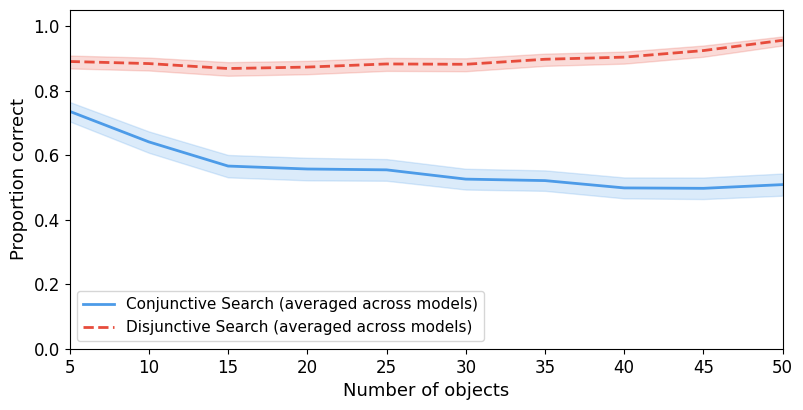

In [19]:
# Visual Search (2D) — Aggregated across models (pooled counts), conjunctive vs disjunctive
# Paste this whole cell and run.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Binomial 95% CI (Wilson)
# ----------------------------
def wilson_ci(k, n, z=1.96):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    low = np.zeros_like(k, dtype=float)
    high = np.zeros_like(k, dtype=float)

    mask = n > 0
    if not np.any(mask):
        return low, high

    phat = np.zeros_like(k, dtype=float)
    phat[mask] = k[mask] / n[mask]

    denom = 1.0 + (z**2) / n[mask]
    center = (phat[mask] + (z**2) / (2.0 * n[mask])) / denom
    half = (z / denom) * np.sqrt(
        (phat[mask] * (1.0 - phat[mask]) + (z**2) / (4.0 * n[mask])) / n[mask]
    )

    low[mask] = np.clip(center - half, 0, 1)
    high[mask] = np.clip(center + half, 0, 1)
    return low, high


# ----------------------------
# Load + prepare visual-search results (per-model pooled)
# ----------------------------
def load_visual_search_csv(path, model_name, warn=True):
    def empty_frame():
        return pd.DataFrame({
            "model": pd.Series(dtype=str),
            "condition_label": pd.Series(dtype=str),
            "n_objects": pd.Series(dtype=int),
            "n_trials": pd.Series(dtype=int),
            "n_correct": pd.Series(dtype=int),
            "accuracy": pd.Series(dtype=float),
            "ci_low": pd.Series(dtype=float),
            "ci_high": pd.Series(dtype=float),
        })

    path = Path(path)
    if not path.exists():
        if warn:
            print(f"[visual_search] Missing CSV for {model_name}: {path}")
        out = empty_frame()
        out["model"] = out["model"].astype(str)
        return out

    df = pd.read_csv(path)
    if df.empty:
        if warn:
            print(f"[visual_search] Empty CSV for {model_name}: {path}")
        out = empty_frame()
        out["model"] = out["model"].astype(str)
        return out

    df["model"] = model_name

    # Robust numeric parsing
    for col in ["n_objects", "n_trials", "n_correct"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    required = ["condition_label", "n_objects", "n_trials", "n_correct"]
    for col in required:
        if col not in df.columns:
            return empty_frame()

    df = df.dropna(subset=required).copy()
    if df.empty:
        return empty_frame()

    df["n_objects"] = df["n_objects"].astype(int)
    df["n_trials"] = df["n_trials"].astype(int)
    df["n_correct"] = df["n_correct"].astype(int)

    # Keep only main conditions
    df = df[df["condition_label"].isin(["disjunctive", "conjunctive"])].copy()
    if df.empty:
        return empty_frame()

    # Per-model pooling in case duplicates
    df = (
        df.groupby(["model", "condition_label", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
          .sum()
          .sort_values(["condition_label", "n_objects"])
    )

    df["accuracy"] = (df["n_correct"] / df["n_trials"]).astype(float)
    lo, hi = wilson_ci(df["n_correct"].values, df["n_trials"].values)
    df["ci_low"] = lo.astype(float)
    df["ci_high"] = hi.astype(float)
    return df


# ----------------------------
# Aggregate across models (pool counts) per condition + n_objects
# ----------------------------
def aggregate_visual_search_across_models(df_all):
    agg = (
        df_all.groupby(["condition_label", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
             .sum()
             .sort_values(["condition_label", "n_objects"])
    )
    agg["accuracy"] = agg["n_correct"] / agg["n_trials"]
    lo, hi = wilson_ci(agg["n_correct"].values, agg["n_trials"].values)
    agg["ci_low"] = lo
    agg["ci_high"] = hi
    return agg


# ----------------------------
# Plot: aggregated curves only (conjunctive vs disjunctive)
# ----------------------------
def plot_visual_search_2d_aggregated_across_models(
    df_all,
    title=None,  # set None to suppress for LaTeX captions
    save_path="./analysis/plots/visual_search_tasks_2d_aggregated_across_models.pdf",
    base_fontsize=13,
    title_fontsize=14,
    legend_fontsize=11,
    tick_fontsize=12,
):
    cond_order = ["conjunctive", "disjunctive"]
    cond_label = {"conjunctive": "Conjunctive Search", "disjunctive": "Disjunctive Search"}
    cond_style = {"conjunctive": "-", "disjunctive": "--"}
    cond_colors = {"conjunctive": "#4C9BE8", "disjunctive": "#E74C3C"}

    agg = aggregate_visual_search_across_models(df_all)

    present = set(agg["condition_label"].unique().tolist())
    cond_order = [c for c in cond_order if c in present]
    if not cond_order:
        raise ValueError("No conjunctive/disjunctive rows found after loading CSVs.")

    fig, ax = plt.subplots(figsize=(9.2, 4.4))

    if title:
        ax.set_title(title, fontsize=title_fontsize)

    for cond in cond_order:
        sub = agg[agg["condition_label"] == cond].sort_values("n_objects")
        if sub.empty:
            continue

        x = sub["n_objects"].to_numpy()
        y = sub["accuracy"].to_numpy()
        lo = sub["ci_low"].to_numpy()
        hi = sub["ci_high"].to_numpy()

        ax.plot(
            x, y,
            linestyle=cond_style[cond],
            color=cond_colors[cond],
            linewidth=2.0,
            label=f"{cond_label[cond]} (averaged across models)",
        )
        ax.fill_between(x, lo, hi, color=cond_colors[cond], alpha=0.20)

    ax.set_xlabel("Number of objects", fontsize=base_fontsize)
    ax.set_ylabel("Proportion correct", fontsize=base_fontsize)
    ax.tick_params(axis="both", labelsize=tick_fontsize)

    ax.set_xlim(agg["n_objects"].min(), agg["n_objects"].max())
    ax.set_ylim(0.0, 1.05)

    ax.legend(frameon=True, fontsize=legend_fontsize)

    if save_path is not None:
        out_path = Path(save_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path, format="pdf", bbox_inches="tight", dpi=300)
        print("Saved to:", out_path.resolve())

    plt.show()


# ----------------------------
# Paths (update if needed)
# ----------------------------
BASE = Path("analysis/results/2D")
model_paths = {
    "Qwen2.5-VL-7B-Instruct": BASE / "qwen2.5-VL-7B-Instruct_visual_search.csv",
    "Qwen2.5-VL-32B": BASE / "qwen2.5-VL-32B-Instruct-AWQ_visual_search.csv",
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_visual_search.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_visual_search.csv",
    "idefics2_8b": BASE / "idefics2_8b_visual_search.csv",
}

all_dfs = [load_visual_search_csv(path, model_name=name) for name, path in model_paths.items()]
df_all = pd.concat(all_dfs, ignore_index=True)

plot_visual_search_2d_aggregated_across_models(
    df_all,
    title=None,  # keep None for LaTeX captions
)


/tmp/ipykernel_27843/2494775474.py:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


Saved to: /home/kelemnegasi/workspace/transformers-project/binding/analysis/final_reports/numerical_estimation_tasks_3d_line_agg_bar_per_model.pdf


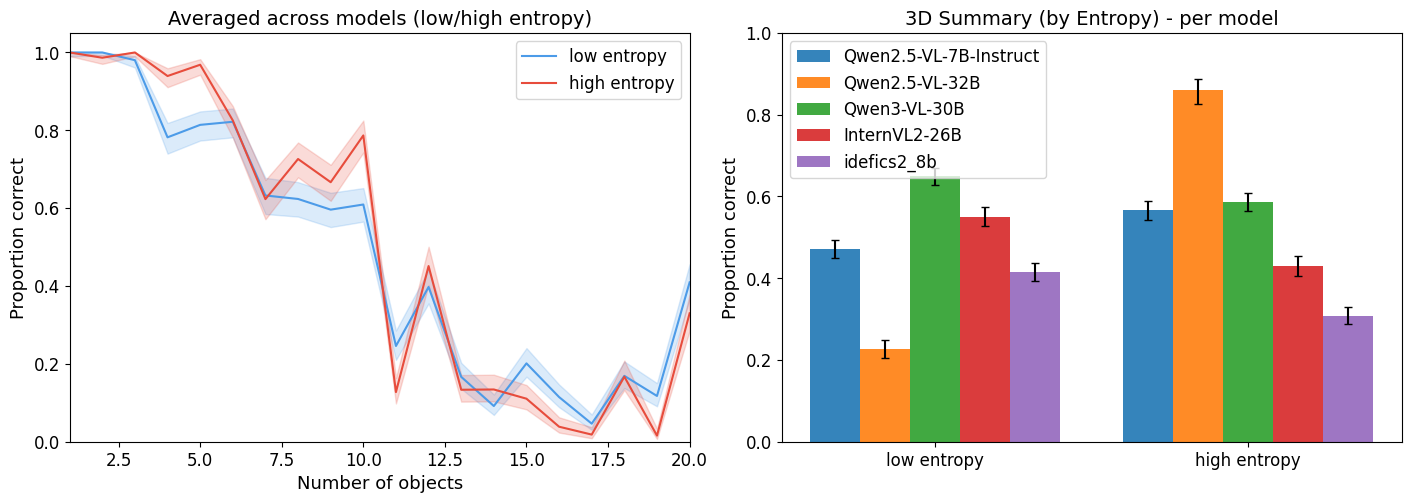

In [2]:
# Numerical Estimation (3D):
# LEFT: line chart aggregated across models (pooled counts) for ONLY low + high entropy
# RIGHT: bar chart kept PER-MODEL (no aggregation) and NO empty "medium" slot if it doesn't exist
# Paste this cell as-is and run.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Binomial 95% CI (Wilson)
# ----------------------------
def wilson_ci(k, n, z=1.96):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    low = np.zeros_like(k, dtype=float)
    high = np.zeros_like(k, dtype=float)

    mask = n > 0
    if not np.any(mask):
        return low, high

    phat = np.zeros_like(k, dtype=float)
    phat[mask] = k[mask] / n[mask]

    denom = 1.0 + (z**2) / n[mask]
    center = (phat[mask] + (z**2) / (2.0 * n[mask])) / denom
    half = (z / denom) * np.sqrt(
        (phat[mask] * (1.0 - phat[mask]) + (z**2) / (4.0 * n[mask])) / n[mask]
    )

    low[mask] = np.clip(center - half, 0, 1)
    high[mask] = np.clip(center + half, 0, 1)
    return low, high

# ----------------------------
# Condition mapping (3D has no medium in your data; we still map it safely)
# ----------------------------
def map_entropy(lbl):
    if lbl == "low_entropy":
        return "low_entropy"
    if lbl == "high_entropy":
        return "high_entropy"
    if lbl in ("medium_entropy_same_shape", "medium_entropy_same_color"):
        return "medium_entropy"
    return None  # ignore other conditions

# ----------------------------
# Per-model pooling (keeps counts)
# ----------------------------
def prepare_pooled(df_raw, model_name):
    df = df_raw.copy()
    df["model"] = model_name
    df["entropy_group"] = df["condition_label"].map(map_entropy)
    df = df[df["entropy_group"].notnull()].copy()

    pooled = (
        df.groupby(["model", "entropy_group", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
          .sum()
          .sort_values(["entropy_group", "n_objects"])
    )
    pooled["accuracy"] = pooled["n_correct"] / pooled["n_trials"]
    lo, hi = wilson_ci(pooled["n_correct"].values, pooled["n_trials"].values)
    pooled["ci_low"] = lo
    pooled["ci_high"] = hi
    return pooled

def summary_by_entropy(pooled_one_model):
    summ = (
        pooled_one_model.groupby(["model", "entropy_group"], as_index=False)[["n_trials", "n_correct"]]
                        .sum()
    )
    summ["accuracy"] = summ["n_correct"] / summ["n_trials"]
    lo, hi = wilson_ci(summ["n_correct"].values, summ["n_trials"].values)
    summ["ci_low"] = lo
    summ["ci_high"] = hi
    return summ

# ----------------------------
# Aggregate ONLY the curve across models (pool counts), for chosen entropies
# ----------------------------
def aggregate_curve_across_models(pooled_by_model, entropy_order):
    all_p = pd.concat(pooled_by_model.values(), ignore_index=True)
    all_p = all_p[all_p["entropy_group"].isin(entropy_order)].copy()

    agg_curve = (
        all_p.groupby(["entropy_group", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
             .sum()
             .sort_values(["entropy_group", "n_objects"])
    )
    agg_curve["accuracy"] = agg_curve["n_correct"] / agg_curve["n_trials"]
    lo, hi = wilson_ci(agg_curve["n_correct"].values, agg_curve["n_trials"].values)
    agg_curve["ci_low"] = lo
    agg_curve["ci_high"] = hi
    return agg_curve

# ----------------------------
# Plot: aggregated curve (left) + per-model bars (right), with NO medium gap
# ----------------------------
def plot_numerical_estimation_3d_line_agg_bar_per_model(
    model_dfs,
    title=None,
    save_path="./analysis/final_reports/numerical_estimation_tasks_3d_line_agg_bar_per_model.pdf",
    base_fontsize=13,
    title_fontsize=14,
    legend_fontsize=12,
    tick_fontsize=12,
):
    if not model_dfs:
        raise ValueError("model_dfs is empty")

    model_names = list(model_dfs.keys())
    n_models = len(model_names)

    pooled = {name: prepare_pooled(df, name) for name, df in model_dfs.items()}
    summ = pd.concat([summary_by_entropy(p) for p in pooled.values()], ignore_index=True)

    # ---- Determine which entropy groups actually exist ----
    preferred_order = ["low_entropy", "high_entropy"]
    present = set(summ["entropy_group"].unique().tolist())
    entropy_order = [g for g in preferred_order if g in present]
    if not entropy_order:
        raise ValueError("No low/high entropy rows found. Check condition_label values in your CSVs.")

    entropy_label = {
        "low_entropy": "low entropy",
        "medium_entropy": "medium entropy",
        "high_entropy": "high entropy",
    }

    # Colors
    entropy_line_colors = {
        "low_entropy": "#4C9BE8",
        "high_entropy": "#E74C3C",
    }
    cmap = plt.cm.get_cmap("tab10")
    model_colors = {name: cmap(i % 10) for i, name in enumerate(model_names)}

    # Build aggregated curve across models for low/high only
    agg_curve = aggregate_curve_across_models(pooled, entropy_order)

    fig, (ax_line, ax_bar) = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
    fig.suptitle(title, fontsize=title_fontsize)

    # ---- LEFT: aggregated line chart ----
    for g in entropy_order:
        sub = agg_curve[agg_curve["entropy_group"] == g].sort_values("n_objects")
        if sub.empty:
            continue
        x = sub["n_objects"].values
        y = sub["accuracy"].values
        lo = sub["ci_low"].values
        hi = sub["ci_high"].values

        ax_line.plot(x, y, label=entropy_label[g], color=entropy_line_colors[g])
        ax_line.fill_between(x, lo, hi, color=entropy_line_colors[g], alpha=0.2)

    ax_line.set_xlim(1, 20)
    ax_line.set_ylim(0, 1.05)
    ax_line.set_xlabel("Number of objects", fontsize=base_fontsize)
    ax_line.set_ylabel("Proportion correct", fontsize=base_fontsize)
    ax_line.set_title("Averaged across models (low/high entropy)", fontsize=title_fontsize)
    ax_line.tick_params(axis="both", labelsize=tick_fontsize)
    ax_line.legend(frameon=True, fontsize=legend_fontsize)

    # ---- RIGHT: per-model bar chart ----
    x_base = np.arange(len(entropy_order))
    bar_w = 0.8 / max(n_models, 1)
    offsets = (np.arange(n_models) - (n_models - 1) / 2.0) * bar_w

    for i, model_name in enumerate(model_names):
        sub = summ[summ["model"] == model_name].set_index("entropy_group")

        accs, el, eh = [], [], []
        for g in entropy_order:
            if g in sub.index:
                a = float(sub.loc[g, "accuracy"])
                lo = float(sub.loc[g, "ci_low"])
                hi = float(sub.loc[g, "ci_high"])
                accs.append(a)
                el.append(a - lo)
                eh.append(hi - a)
            else:
                accs.append(np.nan); el.append(np.nan); eh.append(np.nan)

        x = x_base + offsets[i]
        ax_bar.bar(
            x,
            accs,
            width=bar_w,
            yerr=np.vstack([el, eh]),
            color=model_colors[model_name],
            alpha=0.9,
            capsize=3,
            label=model_name,
        )

    ax_bar.set_xticks(x_base)
    ax_bar.set_xticklabels(
        [entropy_label[g] for g in entropy_order],
        rotation=0,
        fontsize=tick_fontsize,
    )
    ax_bar.set_ylim(0, 1.0)
    ax_bar.set_ylabel("Proportion correct", fontsize=base_fontsize)
    ax_bar.set_title("3D Summary (by Entropy) - per model", fontsize=title_fontsize)
    ax_bar.tick_params(axis="y", labelsize=tick_fontsize)
    ax_bar.legend(frameon=True, fontsize=legend_fontsize, ncol=1)

    # Save
    if save_path is not None:
        out_path = Path(save_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path, format="pdf", bbox_inches="tight", dpi=300)
        print("Saved to:", out_path.resolve())

    plt.show()

# ----------------------------
# Load data + run
# ----------------------------
BASE = Path("analysis/results/3D")
model_paths = {
    "Qwen2.5-VL-7B-Instruct": BASE / "qwen2.5-VL-7B-Instruct_counting.csv",
    "Qwen2.5-VL-32B": BASE / "Qwen2.5-VL-32B-Instruct-AWQ_counting.csv",
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_counting.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_counting.csv",
    "idefics2_8b": BASE / "idefics2_8b_counting.csv",
}

model_dfs = {name: pd.read_csv(path) for name, path in model_paths.items()}

plot_numerical_estimation_3d_line_agg_bar_per_model(model_dfs)


Saved to: /home/kelemnegasi/workspace/transformers-project/binding/analysis/plots/visual_search_tasks_3d_aggregated_across_models.pdf


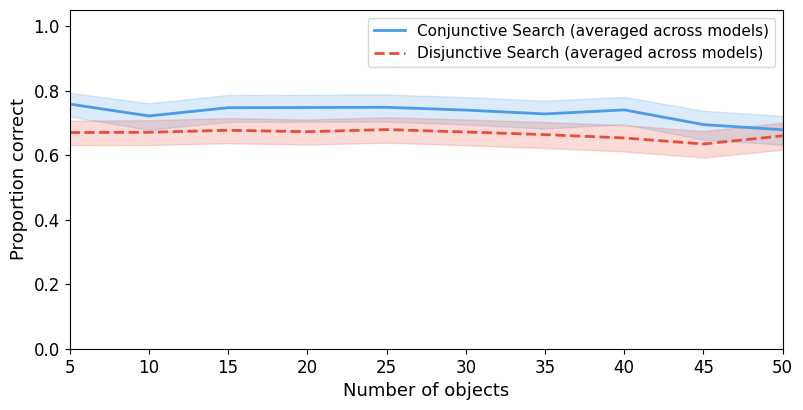

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Binomial 95% CI (Wilson)
# ----------------------------
def wilson_ci(k, n, z=1.96):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    low = np.zeros_like(k, dtype=float)
    high = np.zeros_like(k, dtype=float)

    mask = n > 0
    if not np.any(mask):
        return low, high

    phat = np.zeros_like(k, dtype=float)
    phat[mask] = k[mask] / n[mask]

    denom = 1.0 + (z**2) / n[mask]
    center = (phat[mask] + (z**2) / (2.0 * n[mask])) / denom
    half = (z / denom) * np.sqrt(
        (phat[mask] * (1.0 - phat[mask]) + (z**2) / (4.0 * n[mask])) / n[mask]
    )

    low[mask] = np.clip(center - half, 0, 1)
    high[mask] = np.clip(center + half, 0, 1)
    return low, high


# ----------------------------
# Load + prepare visual-search results (per model pooled)
# ----------------------------
def load_visual_search_csv(path, model_name, warn=True):
    def empty_frame():
        return pd.DataFrame({
            "model": pd.Series(dtype=str),
            "condition_label": pd.Series(dtype=str),
            "n_objects": pd.Series(dtype=int),
            "n_trials": pd.Series(dtype=int),
            "n_correct": pd.Series(dtype=int),
            "accuracy": pd.Series(dtype=float),
            "ci_low": pd.Series(dtype=float),
            "ci_high": pd.Series(dtype=float),
        })

    path = Path(path)
    if not path.exists():
        if warn:
            print(f"[visual_search] Missing CSV for {model_name}: {path}")
        out = empty_frame()
        out["model"] = out["model"].astype(str)
        return out

    df = pd.read_csv(path)
    if df.empty:
        if warn:
            print(f"[visual_search] Empty CSV for {model_name}: {path}")
        out = empty_frame()
        out["model"] = out["model"].astype(str)
        return out

    df["model"] = model_name

    for col in ["n_objects", "n_trials", "n_correct"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    required = ["condition_label", "n_objects", "n_trials", "n_correct"]
    for col in required:
        if col not in df.columns:
            return empty_frame()

    df = df.dropna(subset=required).copy()
    if df.empty:
        return empty_frame()

    df["n_objects"] = df["n_objects"].astype(int)
    df["n_trials"] = df["n_trials"].astype(int)
    df["n_correct"] = df["n_correct"].astype(int)

    df = df[df["condition_label"].isin(["disjunctive", "conjunctive"])].copy()
    if df.empty:
        return empty_frame()

    # per-model pooling (in case duplicates)
    df = (
        df.groupby(["model", "condition_label", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
          .sum()
          .sort_values(["condition_label", "n_objects"])
    )
    df["accuracy"] = (df["n_correct"] / df["n_trials"]).astype(float)
    lo, hi = wilson_ci(df["n_correct"].values, df["n_trials"].values)
    df["ci_low"] = lo.astype(float)
    df["ci_high"] = hi.astype(float)
    return df


# ----------------------------
# Aggregate across models (pool counts) per condition + n_objects
# ----------------------------
def aggregate_visual_search_across_models(df_all):
    agg = (
        df_all.groupby(["condition_label", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
             .sum()
             .sort_values(["condition_label", "n_objects"])
    )
    agg["accuracy"] = agg["n_correct"] / agg["n_trials"]
    lo, hi = wilson_ci(agg["n_correct"].values, agg["n_trials"].values)
    agg["ci_low"] = lo
    agg["ci_high"] = hi
    return agg


# ----------------------------
# Plot: aggregated curves (conjunctive vs disjunctive)
# ----------------------------
def plot_visual_search_agg_across_models(
    df_all,
    title=None,  # set None to avoid global title for LaTeX
    save_path="./analysis/plots/visual_search_tasks_3d_aggregated_across_models.pdf",
    base_fontsize=13,
    title_fontsize=14,
    legend_fontsize=11,
    tick_fontsize=12,
):
    cond_order = ["conjunctive", "disjunctive"]
    cond_label = {"conjunctive": "Conjunctive Search", "disjunctive": "Disjunctive Search"}
    cond_style = {"conjunctive": "-", "disjunctive": "--"}
    cond_colors = {"conjunctive": "#4C9BE8", "disjunctive": "#E74C3C"}

    agg = aggregate_visual_search_across_models(df_all)

    fig, ax = plt.subplots(figsize=(9.2, 4.4))

    if title:
        ax.set_title(title, fontsize=title_fontsize)

    for cond in cond_order:
        sub = agg[agg["condition_label"] == cond].sort_values("n_objects")
        if sub.empty:
            continue

        x = sub["n_objects"].to_numpy()
        y = sub["accuracy"].to_numpy()
        lo = sub["ci_low"].to_numpy()
        hi = sub["ci_high"].to_numpy()

        ax.plot(
            x, y,
            linestyle=cond_style[cond],
            color=cond_colors[cond],
            linewidth=2.0,
            label=f"{cond_label[cond]} (averaged across models)",
        )
        ax.fill_between(x, lo, hi, color=cond_colors[cond], alpha=0.20)

    ax.set_xlabel("Number of objects", fontsize=base_fontsize)
    ax.set_ylabel("Proportion correct", fontsize=base_fontsize)
    ax.tick_params(axis="both", labelsize=tick_fontsize)

    if not agg.empty:
        ax.set_xlim(agg["n_objects"].min(), agg["n_objects"].max())
    ax.set_ylim(0.0, 1.05)

    ax.legend(frameon=True, fontsize=legend_fontsize)

    if save_path is not None:
        out_path = Path(save_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path, format="pdf", bbox_inches="tight", dpi=300)
        print("Saved to:", out_path.resolve())

    plt.show()


# ----------------------------
# Load data + run
# ----------------------------
BASE = Path("analysis/results/3D")
model_paths = {
    "Qwen2.5-VL-7B-Instruct": BASE / "qwen2.5-VL-7B-Instruct_visual_search.csv",
    "Qwen2.5-VL-32B": BASE / "Qwen2.5-VL-32B-Instruct-AWQ_visual_search.csv",
    "Qwen3-VL-30B": BASE / "qwen3-vl-30b-a3b-instruct_visual_search.csv",
    "InternVL2-26B": BASE / "InternVL2-26B_visual_search.csv",
    "idefics2_8b": BASE / "idefics2_8b_visual_search.csv",
}

all_dfs = [load_visual_search_csv(path, model_name=name) for name, path in model_paths.items()]
df_all = pd.concat(all_dfs, ignore_index=True)

plot_visual_search_agg_across_models(
    df_all,
    title=None,  # keep None for LaTeX captions
)


[visual_search] Empty CSV for Qwen2.5-VL-32B: analysis/results/3D/Qwen2.5-VL-32B-Instruct-AWQ_visual_search.csv
Saved to: /home/kelemnegasi/workspace/transformers-project/binding/analysis/final_reports/visual_search_tasks_2d3d_combined_aggregated_across_models.pdf


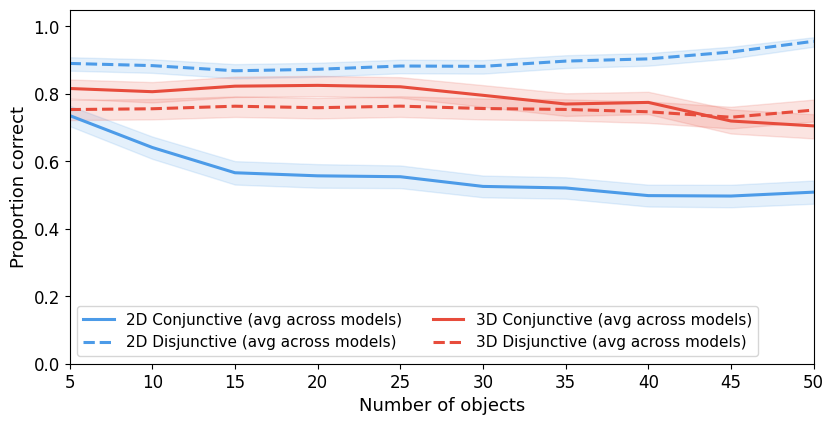

In [1]:
# Visual Search (2D + 3D) — Aggregated across models (pooled counts)
# One plot: 4 curves = {2D,3D} x {conjunctive, disjunctive}, with Wilson CI bands.
# Paste this whole cell and run.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Binomial 95% CI (Wilson)
# ----------------------------
def wilson_ci(k, n, z=1.96):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    low = np.zeros_like(k, dtype=float)
    high = np.zeros_like(k, dtype=float)

    mask = n > 0
    if not np.any(mask):
        return low, high

    phat = np.zeros_like(k, dtype=float)
    phat[mask] = k[mask] / n[mask]

    denom = 1.0 + (z**2) / n[mask]
    center = (phat[mask] + (z**2) / (2.0 * n[mask])) / denom
    half = (z / denom) * np.sqrt(
        (phat[mask] * (1.0 - phat[mask]) + (z**2) / (4.0 * n[mask])) / n[mask]
    )

    low[mask] = np.clip(center - half, 0, 1)
    high[mask] = np.clip(center + half, 0, 1)
    return low, high


# ----------------------------
# Load + prepare visual-search results (per-model pooled)
# ----------------------------
def load_visual_search_csv(path, model_name, warn=True):
    def empty_frame():
        return pd.DataFrame({
            "model": pd.Series(dtype=str),
            "condition_label": pd.Series(dtype=str),
            "n_objects": pd.Series(dtype=int),
            "n_trials": pd.Series(dtype=int),
            "n_correct": pd.Series(dtype=int),
        })

    path = Path(path)
    if not path.exists():
        if warn:
            print(f"[visual_search] Missing CSV for {model_name}: {path}")
        out = empty_frame()
        out["model"] = out["model"].astype(str)
        return out

    df = pd.read_csv(path)
    if df.empty:
        if warn:
            print(f"[visual_search] Empty CSV for {model_name}: {path}")
        out = empty_frame()
        out["model"] = out["model"].astype(str)
        return out

    df["model"] = model_name

    # Robust numeric parsing
    for col in ["n_objects", "n_trials", "n_correct"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    required = ["condition_label", "n_objects", "n_trials", "n_correct"]
    for col in required:
        if col not in df.columns:
            return empty_frame()

    df = df.dropna(subset=required).copy()
    if df.empty:
        return empty_frame()

    df["n_objects"] = df["n_objects"].astype(int)
    df["n_trials"] = df["n_trials"].astype(int)
    df["n_correct"] = df["n_correct"].astype(int)

    # Keep only main conditions
    df = df[df["condition_label"].isin(["disjunctive", "conjunctive"])].copy()
    if df.empty:
        return empty_frame()

    # Per-model pooling in case duplicates
    df = (
        df.groupby(["model", "condition_label", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
          .sum()
          .sort_values(["condition_label", "n_objects"])
    )
    return df


# ----------------------------
# Aggregate across models (pool counts) per condition + n_objects
# ----------------------------
def aggregate_visual_search_across_models(df_all):
    agg = (
        df_all.groupby(["condition_label", "n_objects"], as_index=False)[["n_trials", "n_correct"]]
             .sum()
             .sort_values(["condition_label", "n_objects"])
    )
    agg["accuracy"] = agg["n_correct"] / agg["n_trials"]
    lo, hi = wilson_ci(agg["n_correct"].values, agg["n_trials"].values)
    agg["ci_low"] = lo
    agg["ci_high"] = hi
    return agg


# ----------------------------
# Combined plot: 2D vs 3D, conjunctive vs disjunctive
# ----------------------------
def plot_visual_search_2d3d_combined(
    agg_2d,
    agg_3d,
    title=None,  # set None for LaTeX captions
    save_path="./analysis/final_reports/visual_search_tasks_2d3d_combined_aggregated_across_models.pdf",
    base_fontsize=13,
    title_fontsize=14,
    legend_fontsize=11,
    tick_fontsize=12,
):
    cond_order = ["conjunctive", "disjunctive"]
    cond_label = {"conjunctive": "Conjunctive", "disjunctive": "Disjunctive"}

    # Style: same linestyle for cond, different colors for 2D vs 3D (as requested)
    cond_style = {"conjunctive": "-", "disjunctive": "--"}
    dim_colors = {"2D": "#4C9BE8", "3D": "#E74C3C"}  # 2D blue, 3D red

    fig, ax = plt.subplots(figsize=(9.6, 4.6))

    if title:
        ax.set_title(title, fontsize=title_fontsize)

    def plot_one(agg, dim_tag):
        present = set(agg["condition_label"].unique().tolist())
        for cond in cond_order:
            if cond not in present:
                continue
            sub = agg[agg["condition_label"] == cond].sort_values("n_objects")
            if sub.empty:
                continue
            x = sub["n_objects"].to_numpy()
            y = sub["accuracy"].to_numpy()
            lo = sub["ci_low"].to_numpy()
            hi = sub["ci_high"].to_numpy()

            ax.plot(
                x, y,
                linestyle=cond_style[cond],
                color=dim_colors[dim_tag],
                linewidth=2.2,
                label=f"{dim_tag} {cond_label[cond]} (avg across models)",
            )
            ax.fill_between(x, lo, hi, color=dim_colors[dim_tag], alpha=0.15)

    plot_one(agg_2d, "2D")
    plot_one(agg_3d, "3D")

    # Axes styling
    ax.set_xlabel("Number of objects", fontsize=base_fontsize)
    ax.set_ylabel("Proportion correct", fontsize=base_fontsize)
    ax.tick_params(axis="both", labelsize=tick_fontsize)
    ax.set_ylim(0.0, 1.05)

    # X-limits across both datasets (so lines share a common axis)
    x_min = np.nanmin([agg_2d["n_objects"].min() if not agg_2d.empty else np.nan,
                       agg_3d["n_objects"].min() if not agg_3d.empty else np.nan])
    x_max = np.nanmax([agg_2d["n_objects"].max() if not agg_2d.empty else np.nan,
                       agg_3d["n_objects"].max() if not agg_3d.empty else np.nan])
    if np.isfinite(x_min) and np.isfinite(x_max):
        ax.set_xlim(int(x_min), int(x_max))

    ax.legend(frameon=True, fontsize=legend_fontsize, ncol=2)

    if save_path is not None:
        out_path = Path(save_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path, format="pdf", bbox_inches="tight", dpi=300)
        print("Saved to:", out_path.resolve())

    plt.show()


# ----------------------------
# Load data (2D + 3D) + run
# ----------------------------
BASE_2D = Path("analysis/results/2D")
model_paths_2d = {
    "Qwen2.5-VL-7B-Instruct": BASE_2D / "qwen2.5-VL-7B-Instruct_visual_search.csv",
    "Qwen2.5-VL-32B": BASE_2D / "qwen2.5-VL-32B-Instruct-AWQ_visual_search.csv",
    "Qwen3-VL-30B": BASE_2D / "qwen3-vl-30b-a3b-instruct_visual_search.csv",
    "InternVL2-26B": BASE_2D / "InternVL2-26B_visual_search.csv",
    "idefics2_8b": BASE_2D / "idefics2_8b_visual_search.csv",
}

BASE_3D = Path("analysis/results/3D")
model_paths_3d = {
    "Qwen2.5-VL-7B-Instruct": BASE_3D / "qwen2.5-VL-7B-Instruct_visual_search.csv",
    "Qwen2.5-VL-32B": BASE_3D / "Qwen2.5-VL-32B-Instruct-AWQ_visual_search.csv",
    "Qwen3-VL-30B": BASE_3D / "qwen3-vl-30b-a3b-instruct_visual_search.csv",
    "InternVL2-26B": BASE_3D / "InternVL2-26B_visual_search.csv",
    "idefics2_8b": BASE_3D / "idefics2_8b_visual_search.csv",
}

df_2d = pd.concat(
    [load_visual_search_csv(path, model_name=name) for name, path in model_paths_2d.items()],
    ignore_index=True
)
df_3d = pd.concat(
    [load_visual_search_csv(path, model_name=name) for name, path in model_paths_3d.items()],
    ignore_index=True
)

agg_2d = aggregate_visual_search_across_models(df_2d)
agg_3d = aggregate_visual_search_across_models(df_3d)

plot_visual_search_2d3d_combined(
    agg_2d,
    agg_3d,
    title=None,  # keep None for LaTeX captions
)